# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [2]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [3]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # First Convolutional Layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # Second Convolutional Layer
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # First Fully Connected Layer
        self.fc1 = torch.nn.Linear(in_features=16*4*4, out_features=120)

        # Second Fully Connected Layer
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)

        # Output Layer
        self.fc3 = torch.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Apply first convolutional layer + ReLU + Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Apply second convolutional layer + ReLU + Max Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the feature maps
        x = x.view(x.size(0), -1)

        # Apply first fully connected layer + ReLU
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer + ReLU
        x = F.relu(self.fc2(x))

        # Apply output layer (no activation function here, typically softmax is applied during evaluation)
        x = self.fc3(x)

        return x


### Define cost function

In [7]:
import torch.nn as nn

def get_cost_function():
    cost_function = nn.CrossEntropyLoss()
    return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [8]:
import torch.optim as optim

def get_optimizer(net, lr, wd, momentum):
    optimizer = optim.SGD(
        net.parameters(),  # Parameters to optimize
        lr=lr,             # Learning rate
        weight_decay=wd,   # Weight decay (L2 regularization)
        momentum=momentum   # Momentum factor
    )
    return optimizer


### Train and test functions

In [9]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [10]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [12]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

  net = LeNet().to(device)

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [13]:
main()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17961047.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 485278.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2472440.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4944336.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Before training:
	 Training loss 0.01806, Training accuracy 8.97
	 Validation loss 0.00907, Validation accuracy 9.01
	 Test loss 0.00922, Test accuracy 8.49
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00811, Training accuracy 65.62
	 Validation loss 0.00078, Validation accuracy 94.06
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00122, Training accuracy 95.02
	 Validation loss 0.00049, Validation accuracy 96.14
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00078, Training accuracy 96.78
	 Validation loss 0.00040, Validation accuracy 96.83
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00060, Training accuracy 97.57
	 Validation loss 0.00034, Validation accuracy 97.36
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00052, Training accuracy 97

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def get_predictions(net, data_loader, device='cuda:0'):
    net.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = net(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_targets), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.show()

def main(batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

    train_loader, val_loader, test_loader = get_data(batch_size)

    # Define LeNet-5
    net = LeNet().to(device)

    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
    cost_function = get_cost_function()

    print('Before training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    for e in range(epochs):
        train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test(net, val_loader, cost_function)
        print('Epoch: {:d}'.format(e+1))
        print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
        print('-----------------------------------------------------')

    print('After training:')
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    return net, test_loader  # Return net and test_loader for further use


Before training:
	 Training loss 0.01807, Training accuracy 9.05
	 Validation loss 0.00908, Validation accuracy 9.02
	 Test loss 0.00923, Test accuracy 8.92
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00896, Training accuracy 60.13
	 Validation loss 0.00093, Validation accuracy 92.58
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00128, Training accuracy 94.90
	 Validation loss 0.00052, Validation accuracy 95.89
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00081, Training accuracy 96.76
	 Validation loss 0.00038, Validation accuracy 97.04
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00063, Training accuracy 97.51
	 Validation loss 0.00031, Validation accuracy 97.53
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00051, Training accuracy 97.89
	 Validation loss 0.00026, Validation accuracy 97.89
------------------

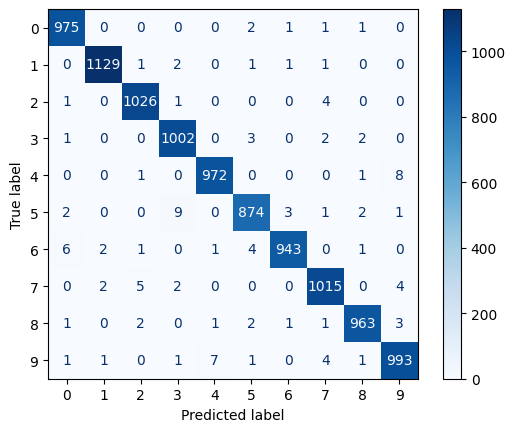

In [18]:
net, test_loader = main()

# Determine if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
net.to(device)

# After training
test_targets, test_preds = get_predictions(net, test_loader, device)
class_names = [str(i) for i in range(10)]  # MNIST has 10 classes (0-9)
plot_confusion_matrix(test_targets, test_preds, class_names)

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.



